### Import libraries and functions

In [1]:
import pandas as pd
import numpy as np
import ast

import scipy.stats as stats
from sklearn.utils.fixes import loguniform
import scipy as sp
from scipy.sparse import hstack
from collections import Counter

from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import MultiLabelBinarizer

from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
#from xgboost import XGBClassifier
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.multiclass import OneVsRestClassifier
from sklearn.multioutput import MultiOutputClassifier, ClassifierChain
from skmultilearn.problem_transform import LabelPowerset

In [32]:
def extend_list(tags):
    retlist = []
    for tag in tags:
        retlist.extend(tag)
    return set(retlist)

def Accuracy(y_true, y_pred):
    """
    Accuracy based on Jaccard Similarity Score
    :param y_true: ground truth
    :param y_pred: prediction
    :return: Jaccard Similarity Score
    """
    jaccard = np.minimum(y_true, y_pred).sum(axis=1) / np.maximum(y_true, y_pred).sum(axis=1)
    return jaccard.mean()


def print_ml_score(y_test, y_pred, clf):
    print('Classifier: ', clf.__class__.__name__)
    print('Accuracy Score: {}'.format(Accuracy(y_test, y_pred)))
    print("-----------------------------------")


def train_model(classifier, feature_vector_train, label_train, feature_vector_test, label_test):
    # fit the training set on the classifier
    clf = OneVsRestClassifier(classifier)
    clf.fit(feature_vector_train, label_train)

    # predict the labels on test set
    predictions = clf.predict(feature_vector_test)
    #print(pd.DataFrame(predictions, columns = multilabel.classes_))
    return print_ml_score(label_test, predictions, classifier)

def get_vec(x):
    doc = nlp(x)
    vec = doc.vector
    return vec

### Load Data

In [3]:
authors = pd.read_csv("../data/coauthor_list.csv")
authors.tags = authors.tags.apply(lambda tag: ast.literal_eval(tag))
authors.idauthor = authors.idauthor.apply(lambda author: author.replace(" ", ""))

# keep JEL code different from letter Y, A and B

#authors['keep'] = authors.tags.apply(lambda tags: 'Y' not in tags)
#authors = authors[authors.keep == True]
#authors

authors['keep'] = authors.tags.apply(lambda tags: 'Y' not in tags)
authors = authors[authors.keep == True]
authors['keep'] = authors.tags.apply(lambda tags: 'A' not in tags)
authors = authors[authors.keep == True]
authors['keep'] = authors.tags.apply(lambda tags: 'B' not in tags)
authors = authors[authors.keep == True]
authors.head()

,tags,title,idauthor,author,keep
0,"[O, D, G, E]",optimal adoption of complementary technologies,p00681,boyan jovanovic,True
0,"[O, D, G, E]",optimal adoption of complementary technologies,p01338,dmitriy stolyarov,True
1,"[G, E]",collateral damage: effects of the japanese ban...,p01546,eric rosengren,True
1,"[G, E]",collateral damage: effects of the japanese ban...,p02544,joe peek,True
2,[J],endogenous inequality in integrated labor mark...,p00544,avner shaked,True


In [4]:
authors_tags = authors.groupby("idauthor").agg({"tags": lambda tags: list(extend_list(tags))})
authors_tags['idauthor'] = authors_tags.index

# keep JEL code different from letter Y, A and B

#authors_tags['keep'] = authors_tags.tags.apply(lambda tags: 'Y' not in tags)
#authors_tags = authors_tags[authors_tags.keep == True]
#authors_tags

authors_tags['keep'] = authors_tags.tags.apply(lambda tags: 'Y' not in tags)
authors_tags = authors_tags[authors_tags.keep == True]
authors_tags['keep'] = authors_tags.tags.apply(lambda tags: 'A' not in tags)
authors_tags = authors_tags[authors_tags.keep == True]
authors_tags['keep'] = authors_tags.tags.apply(lambda tags: 'B' not in tags)
authors_tags = authors_tags[authors_tags.keep == True]
authors.head()

,tags,title,idauthor,author,keep
0,"[O, D, G, E]",optimal adoption of complementary technologies,p00681,boyan jovanovic,True
0,"[O, D, G, E]",optimal adoption of complementary technologies,p01338,dmitriy stolyarov,True
1,"[G, E]",collateral damage: effects of the japanese ban...,p01546,eric rosengren,True
1,"[G, E]",collateral damage: effects of the japanese ban...,p02544,joe peek,True
2,[J],endogenous inequality in integrated labor mark...,p00544,avner shaked,True


In [5]:
# creating  dictionary for the authors and its tags
authors_dict = {}
for i, row in authors_tags.iterrows():

    authors_dict[row.idauthor] = {"tags": row.tags, "hasConnection": []}


In [6]:
from sklearn.preprocessing import MultiLabelBinarizer

multilabel = MultiLabelBinarizer()
y = multilabel.fit_transform(authors['tags'])
pd.DataFrame(y, columns = multilabel.classes_)

,C,D,E,F,G,H,I,J,K,L,M,N,O,P,Q,R,Z
0,0,1,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0
1,0,1,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0
2,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7110,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7111,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0
7112,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0
7113,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0


In [7]:
# grouping author by title of paper
papers_grouped = authors.groupby("title").agg({"idauthor": lambda authors: list(authors)})
papers_grouped['title'] = papers_grouped.index
papers_grouped.index = range(len(papers_grouped))
papers_grouped


,idauthor,title
0,"[p01714, p02726, p03637]","$1,000 cash back: the pass-through of auto man..."
1,"[p00226, p03171, p05209]",'acting wife': marriage market incentives and ...
2,"[p00198, p02336, p02575]","(mis)allocation, market power, and global oil ..."
3,"[p05429, p05611]",a bayesian approach to uncertainty aversion
4,"[p01353, p04127]",a bias–reduced log–periodogram regression esti...
...,...,...
3085,[p00122],"yours, mine, and ours: do divorce laws affect ..."
3086,"[p00381, p04476, p05132]",zombie lending and depressed restructuring in ...
3087,[p04412],“data monkeys”: a procedural model of extrapol...
3088,"[p04020, p05368]",“high” achievers? cannabis access and academic...


In [8]:
for i, row in papers_grouped.iterrows():
    for author in row.idauthor:
        authors_dict[author]['hasConnection'].extend(set(row.idauthor).difference({author}))

In [9]:
for author in authors_dict:
    authors_dict[author]['hasConnection'] = list(set(authors_dict[author]['hasConnection']))

In [10]:
# example with author "p00062"
authors_dict[authors_dict["p00062"]["hasConnection"][0]]

{'tags': ['G', 'J', 'D', 'C'], 'hasConnection': ['p03719', 'p00062']}

In [11]:
# found all JELcodes from coauthors
for author in authors_dict:
    new_tags = []
    for connected_author in authors_dict[author]['hasConnection']:
        new_tags.extend(authors_dict[connected_author]["tags"])
    new_tags = list(set(new_tags))
    authors_dict[author]["level1_tags"] = new_tags
    authors_dict[author]["level1_tags"].extend(authors_dict[author]['tags'])
    authors_dict[author]["level1_tags"] = list(set(authors_dict[author]["level1_tags"]))

In [12]:
# example with author p00062
authors_dict[authors_dict["p00062"]["hasConnection"][0]]

{'tags': ['G', 'J', 'D', 'C'],
 'hasConnection': ['p03719', 'p00062'],
 'level1_tags': ['G', 'D', 'J', 'C']}

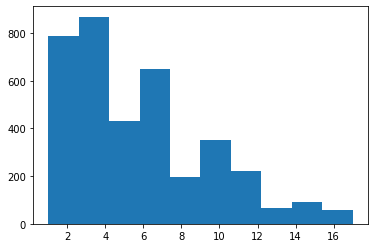

In [13]:
# length of JELcodes by author
import matplotlib.pyplot as plt

n_tags = []
for author in authors_dict:
    n_tags.append(len(authors_dict[author]["level1_tags"]))

_ = plt.hist(n_tags)


In [14]:
# converting tags in one-hot encoding
for author in authors_dict:
    authors_dict[author]["coded_tags"] = np.sum(multilabel.transform(authors_dict[author]["level1_tags"]), axis=0)

In [15]:
# example with author p00062
authors_dict[authors_dict["p00062"]["hasConnection"][0]]

{'tags': ['G', 'J', 'D', 'C'],
 'hasConnection': ['p03719', 'p00062'],
 'level1_tags': ['G', 'D', 'J', 'C'],
 'coded_tags': array([1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0])}

In [16]:
# creating a author dataframe with connections (graphframe)
authors_graphframe = pd.DataFrame(authors_dict)
authors_graphframe = authors_graphframe.T
authors_graphframe['idauthor'] = authors_graphframe.index
authors_graphframe.to_csv('../data/couathor_graphframe_v02.csv', index=False)
authors_graphframe.head()

,tags,hasConnection,level1_tags,coded_tags,idauthor
p00001,"[I, H, O]","[p02522, p00075, p02923]","[D, O, H, I, M, J, C]","[1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, ...",p00001
p00003,[H],[p04319],[H],"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",p00003
p00004,"[E, F, O]","[p03521, p04645, p01781]","[E, D, O, F, N, R, J, C, G]","[1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, ...",p00004
p00006,"[G, F, P, O]",[p00511],"[G, F, P, O]","[0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, ...",p00006
p00008,"[I, J, O]","[p00110, p02923]","[O, H, I, M, J, C]","[1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, ...",p00008


### Machine Learning + Network Co-authorship

In [17]:
# load data
df = pd.read_csv("../data/traning_data_cleaned_v03.csv")

In [18]:
#df.author = df.author.apply(lambda author: author.replace(" ",""))
#df = df[["title_x", "abstract", "tags", "idauthor"]]
df['tags'] = df['tags'].apply(lambda x: ast.literal_eval(x))

df['keep'] = df.tags.apply(lambda tags: 'Y' not in tags)
df = df[df.keep == True]
df['keep'] = df.tags.apply(lambda tags: 'A' not in tags)
df = df[df.keep == True]
df['keep'] = df.tags.apply(lambda tags: 'B' not in tags)
df = df[df.keep == True]
df.head()

,title_x,abstract,tags,idauthor,all_text,cleaned_abstract,cleaned_all_text,keep
0,optimal adoption of complementary technologies,When a production process requires two extreme...,"[O, D, G, E]","['p00681', 'p01338']",optimal adoption of complementary technologies...,production process require two extremely compl...,optimal adoption complementary technologies pr...,True
1,collateral damage: effects of the japanese ban...,The Japanese banking crisis provides a natural...,"[G, E]","['p01546', 'p02544']",collateral damage: effects of the japanese ban...,japanese bank crisis provide natural experimen...,collateral damage effect japanese bank crisis...,True
2,endogenous inequality in integrated labor mark...,We consider a market with red and green worker...,[J],"['p00544', 'p01874', 'p03092']",endogenous inequality in integrated labor mark...,consider market red green workers label payof...,endogenous inequality integrate labor market t...,True
3,"labor-market integration, investment in risky ...",This paper presents a general-equilibrium mode...,"[J, R]",['p01266'],"labor-market integration, investment in risky ...",present general-equilibrium human capital inve...,labor-market integration investment risky hum...,True
4,unequal societies: income distribution and the...,This paper develops a theory of inequality and...,"[P, E, I, D]",['p04639'],unequal societies: income distribution and the...,develop theory inequality social contract aim ...,unequal societies income distribution social ...,True


In [19]:
df['idauthor'] = df['idauthor'].apply(lambda authors: ast.literal_eval(authors)[0])
df.head()

,title_x,abstract,tags,idauthor,all_text,cleaned_abstract,cleaned_all_text,keep
0,optimal adoption of complementary technologies,When a production process requires two extreme...,"[O, D, G, E]",p00681,optimal adoption of complementary technologies...,production process require two extremely compl...,optimal adoption complementary technologies pr...,True
1,collateral damage: effects of the japanese ban...,The Japanese banking crisis provides a natural...,"[G, E]",p01546,collateral damage: effects of the japanese ban...,japanese bank crisis provide natural experimen...,collateral damage effect japanese bank crisis...,True
2,endogenous inequality in integrated labor mark...,We consider a market with red and green worker...,[J],p00544,endogenous inequality in integrated labor mark...,consider market red green workers label payof...,endogenous inequality integrate labor market t...,True
3,"labor-market integration, investment in risky ...",This paper presents a general-equilibrium mode...,"[J, R]",p01266,"labor-market integration, investment in risky ...",present general-equilibrium human capital inve...,labor-market integration investment risky hum...,True
4,unequal societies: income distribution and the...,This paper develops a theory of inequality and...,"[P, E, I, D]",p04639,unequal societies: income distribution and the...,develop theory inequality social contract aim ...,unequal societies income distribution social ...,True


In [20]:
df_merged = df.merge(authors_graphframe, on='idauthor')
df_merged.tail()

,title_x,abstract,tags_x,idauthor,all_text,cleaned_abstract,cleaned_all_text,keep,tags_y,hasConnection,level1_tags,coded_tags
3087,the effect of product misperception on economi...,Panel and experimental data are used to analys...,"[G, D]",p02730,the effect of product misperception on economi...,panel experimental data use analyse economic o...,effect product misperception economic outcomes...,True,"[G, D]",[p05649],"[G, D]","[0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3088,house price beliefs and mortgage leverage choice,We study the relationship between homebuyers' ...,"[D, R, G, E]",p01403,house price beliefs and mortgage leverage choi...,study relationship homebuyers beliefs future ...,house price beliefs mortgage leverage choice s...,True,"[G, E, R, D]","[p02570, p03664, p05182, p00426]","[E, L, D, R, G]","[0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ..."
3089,the impact of consumer credit access on unempl...,Unemployed households' access to unsecured rev...,"[J, G, E]",p03070,the impact of consumer credit access on unempl...,unemployed households access unsecured revolv...,impact consumer credit access unemployment une...,True,"[G, E, J]",[],"[G, J, E]","[0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ..."
3090,extended gravity,Exporting firms often enter foreign markets th...,"[L, F]",p00323,extended gravity Exporting firms often enter f...,export firm often enter foreign market similar...,extend gravity export firm often enter foreign...,True,"[F, L]","[p01408, p01944]","[E, L, D, F, H, R, J, C]","[1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, ..."
3091,deforestation in the amazon: a unified framewo...,Deforestation is a matter of pressing global c...,"[L, Q]",p01410,deforestation in the amazon: a unified framewo...,deforestation matter press global concern yet...,deforestation amazon unify framework estimati...,True,"[Q, L]",[],"[Q, L]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, ..."


In [21]:
tfidf_vect_ngram = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}',
                                   ngram_range=(1,3), max_features=3000)

X_tfidf_ngram = tfidf_vect_ngram.fit_transform(df['cleaned_all_text'])

print('X with TfIdf Ngram Vec Shape: ', X_tfidf_ngram.shape)


X with TfIdf Ngram Vec Shape:  (3092, 3000)


In [22]:
# Auxiliary JEL codes from co-authors
aid_tags = df_merged.coded_tags.to_list()
aid_tags = np.asarray(aid_tags)
aid_tags.shape

(3092, 17)

In [23]:
feats = hstack((X_tfidf_ngram, aid_tags))
feats.shape

(3092, 3017)

In [24]:
# Convert outcome variable to one-hot encoding type
multilabel = MultiLabelBinarizer()
y = multilabel.fit_transform(df['tags'])
pd.DataFrame(y, columns = multilabel.classes_)

,C,D,E,F,G,H,I,J,K,L,M,N,O,P,Q,R,Z
0,0,1,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0
1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
4,0,1,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3087,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3088,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0
3089,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3090,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0


In [25]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(feats, y,
                                                    test_size=0.2,
                                                    random_state=123)
#X_train, X_test = embeddings[train_inds], embeddings[test_inds]
#y_aid_train, y_aid_test = aid_tags[train_inds], aid_tags[test_inds]

In [26]:
# set models
sgd = SGDClassifier(class_weight='balanced')
lr = LogisticRegression( class_weight='balanced')
svc = LinearSVC(class_weight='balanced')
rf = RandomForestClassifier()
naive = MultinomialNB()

In [27]:
# training using tfidf ngram vectorizer
for classifier in [sgd, lr, svc]:
    train_model(classifier, X_train, y_train, X_test, y_test)

Classifier:  SGDClassifier
Accuracy Score: 0.5005256814626767
-----------------------------------
Classifier:  LogisticRegression
Accuracy Score: 0.5630202323255634
-----------------------------------
Classifier:  LinearSVC
Accuracy Score: 0.5491114701130856
-----------------------------------


In [28]:
clf = OneVsRestClassifier(LogisticRegression(solver = 'lbfgs', class_weight='balanced'))
clf.fit(X_train, y_train)

# predict the labels on test set

predictions = clf.predict(X_test)

In [87]:
print(classification_report(y_test, predictions, target_names=multilabel.classes_))

              precision    recall  f1-score   support

           C       0.63      0.69      0.66       128
           D       0.75      0.74      0.74       289
           E       0.74      0.79      0.76       139
           F       0.81      0.76      0.79        84
           G       0.69      0.76      0.72        94
           H       0.50      0.64      0.56        86
           I       0.70      0.78      0.74        78
           J       0.66      0.74      0.70       136
           K       0.41      0.42      0.41        31
           L       0.58      0.73      0.64       114
           M       0.32      0.43      0.37        21
           N       0.35      0.39      0.37        28
           O       0.58      0.64      0.60       102
           P       0.15      0.25      0.19        12
           Q       0.73      0.36      0.48        22
           R       0.54      0.69      0.61        29
           Z       0.35      0.50      0.41        12

   micro avg       0.64   

In [85]:
test_pred = (clf.predict_proba(X_test) >= 0.55).astype(int)

print(classification_report(y_test, test_pred))


              precision    recall  f1-score   support

           0       0.69      0.62      0.65       128
           1       0.79      0.64      0.71       289
           2       0.77      0.71      0.74       139
           3       0.84      0.70      0.77        84
           4       0.74      0.71      0.72        94
           5       0.54      0.56      0.55        86
           6       0.75      0.74      0.75        78
           7       0.73      0.70      0.71       136
           8       0.61      0.35      0.45        31
           9       0.61      0.66      0.64       114
          10       0.38      0.38      0.38        21
          11       0.42      0.36      0.38        28
          12       0.64      0.57      0.60       102
          13       0.11      0.17      0.13        12
          14       0.78      0.32      0.45        22
          15       0.66      0.66      0.66        29
          16       0.43      0.50      0.46        12

   micro avg       0.69   

/Users/c02g40n7q05p/opt/anaconda3/envs/JELcodes_prediction/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Word Embeddings


In [30]:
import spacy
import en_core_web_lg
nlp = en_core_web_lg.load()


In [33]:
# applying word2vec
df['vec'] = df['cleaned_all_text'].apply(lambda x: get_vec(x))

In [37]:
# reshaping vector representation
X = df['vec'].to_numpy()
X = X.reshape(-1,1)

X = np.concatenate(np.concatenate(X, axis=0), axis = 0).reshape(-1,300)

Matrix of Features Shape:  (3092, 300)
Matrix of Coauthor Shape:  (3092, 17)


In [49]:
X_emb = pd.DataFrame(X)
aid_tags_df = pd.DataFrame(aid_tags)

print('Matrix of Features Shape: ', X_emb.shape)
print('Matrix of Coauthor Shape: ', aid_tags_df.shape)

Matrix of Features Shape:  (3092, 300)
Matrix of Coauthor Shape:  (3092, 17)


In [50]:
# adding vectors from coauthor
feats_emb = pd.concat([X_emb, aid_tags_df], axis = 1)
feats_emb.shape


(3092, 317)

In [51]:
# Convert outcome variable to one-hot encoding type
multilabel = MultiLabelBinarizer()
y = multilabel.fit_transform(df['tags'])

In [52]:
xtrain, xtest, ytrain, ytest = train_test_split(feats_emb, y, test_size=0.2, random_state=123)


#### Training Model (with word2vec)


In [53]:
# set models
sgd = SGDClassifier(class_weight='balanced')
lr = LogisticRegression( class_weight='balanced')
svc = LinearSVC(class_weight='balanced')
rf = RandomForestClassifier()
#naive = MultinomialNB()

In [58]:
# training using word2vec representation
for classifier in [sgd, lr, svc, rf]:
    train_model(classifier, xtrain, ytrain, xtest, ytest)

Classifier:  SGDClassifier
Accuracy Score: 0.3397344667538528
-----------------------------------


/Users/c02g40n7q05p/opt/anaconda3/envs/JELcodes_prediction/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/c02g40n7q05p/opt/anaconda3/envs/JELcodes_prediction/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
   

Classifier:  LogisticRegression
Accuracy Score: 0.4701816806421007
-----------------------------------


/Users/c02g40n7q05p/opt/anaconda3/envs/JELcodes_prediction/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/c02g40n7q05p/opt/anaconda3/envs/JELcodes_prediction/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/c02g40n7q05p/opt/anaconda3/envs/JELcodes_prediction/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/c02g40n7q05p/opt/anaconda3/envs/JELcodes_prediction/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed 

Classifier:  LinearSVC
Accuracy Score: 0.47479998461420103
-----------------------------------
Classifier:  RandomForestClassifier
Accuracy Score: 0.3925686591276252
-----------------------------------


In [61]:
clf2 = OneVsRestClassifier(LinearSVC(class_weight='balanced'))
clf2.fit(xtrain, ytrain)

# predict the labels on test set

predictions2 = clf2.predict(xtest)

/Users/c02g40n7q05p/opt/anaconda3/envs/JELcodes_prediction/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/c02g40n7q05p/opt/anaconda3/envs/JELcodes_prediction/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/c02g40n7q05p/opt/anaconda3/envs/JELcodes_prediction/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/c02g40n7q05p/opt/anaconda3/envs/JELcodes_prediction/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed 

In [62]:
print(classification_report(ytest, predictions2))

              precision    recall  f1-score   support

           0       0.52      0.67      0.59       128
           1       0.72      0.74      0.73       289
           2       0.58      0.82      0.68       139
           3       0.55      0.74      0.63        84
           4       0.51      0.78      0.62        94
           5       0.39      0.67      0.49        86
           6       0.59      0.86      0.70        78
           7       0.61      0.73      0.66       136
           8       0.40      0.61      0.48        31
           9       0.49      0.76      0.59       114
          10       0.14      0.43      0.21        21
          11       0.26      0.54      0.35        28
          12       0.52      0.71      0.60       102
          13       0.10      0.33      0.15        12
          14       0.43      0.68      0.53        22
          15       0.26      0.69      0.38        29
          16       0.24      0.67      0.36        12

   micro avg       0.51   

/Users/c02g40n7q05p/opt/anaconda3/envs/JELcodes_prediction/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
